# Гладких Андрей, группа 9383

# Практическая работа №1: Изучение возможности библиотек Python для решения задач цифровой обработки сигналов

 ### Вариант 2.

In [1]:
import wave
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
def getSampleAt(wav, index):
    wav.setpos(index)
    return np.frombuffer(wav.readframes(1), dtype=np.int16)[0]

def writeWav(fileName, params, data):
    wavToWrite = wave.open(str(fileName) + ".wav", "wb")
    wavToWrite.setparams(params)
    wavToWrite.writeframes(np.array(data, dtype="int16").tobytes())
    wavToWrite.close()

wavFile = wave.open("03-01-05-01-02-01-02_A2.wav", "rb")

samplesAmount = wavFile.getnframes()
rawWavX = range(samplesAmount)
rawWavY = [getSampleAt(wavFile, i) for i in range(samplesAmount)]

## 1. Загрузка аудио сигнала и построение огибающей

Имеется сигнал ${x(i), i = 0,1, . . . ,N - 1}$. Хотим построить огибающую ${y(j), j = 0,1, . . . ,n - 1}$.
Пусть ${m = \left [ \frac{N}{n}  \right ]}$ — число точек в интервале усреднения. Тогда ${y(j) = \frac {1}{m} \sum_{k=mj}^{k=mj + m -1} \left | x(k) \right | }$

In [3]:
def envelopeFunction(originalTrack, index, avgIntervalLength):
    sumOfPoints = 0
    for i in range(avgIntervalLength * index, avgIntervalLength * index + avgIntervalLength):
        sumOfPoints += abs(getSampleAt(originalTrack, i))
    
    return sumOfPoints // avgIntervalLength

In [4]:
steps = 1000
envelopeFunctionX = [i for i in range(steps)]

stepLength = samplesAmount // len(envelopeFunctionX)

envelopeFunctionY = [envelopeFunction(wavFile, i, stepLength) for i in envelopeFunctionX]
envelopeFunctionPlotX = [i * stepLength for i in envelopeFunctionX]

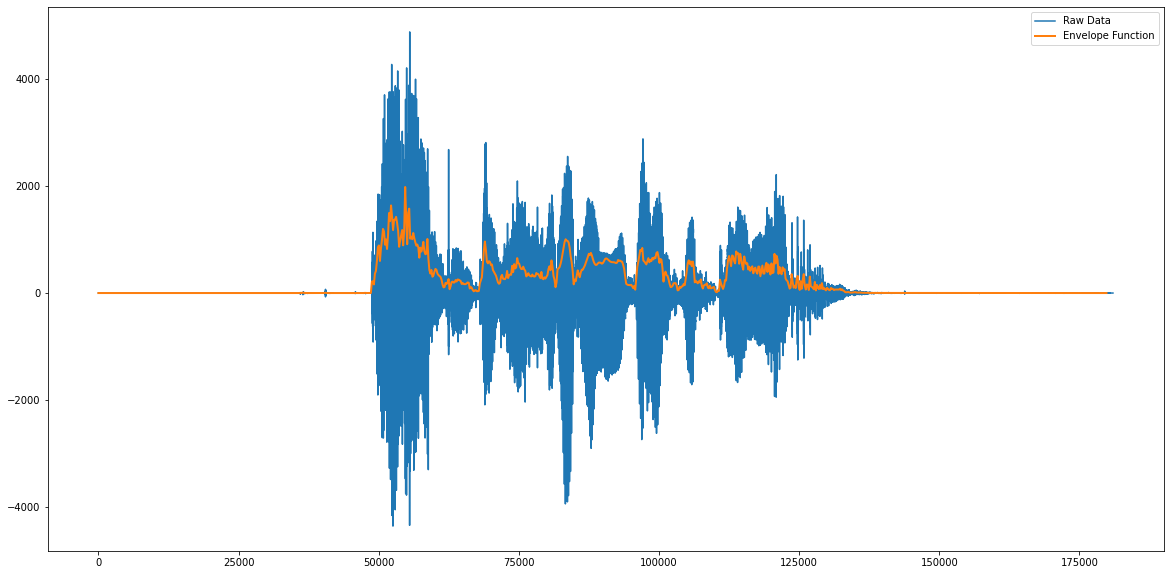

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

ax.plot(rawWavX, rawWavY, label = "Raw Data")
ax.plot(envelopeFunctionPlotX, envelopeFunctionY, label="Envelope Function", linewidth=2)
ax.legend()

Синим цветов обозначен исходный сигнал, оранжевым - огибающая.

## 2. Фильтрация

Сымитируем полосно-заграждающий фильтр. Пусть ${F_d}$ — частота дискретизации, порядок фильтра — ${m}$. Тогда фильтр будет задаваться двумя частотами ${wn_1 = 2 \frac {startFreq} {F_d}}$ и ${wn_2 = 2 \frac {endFreq} {F_d}}$ - началом и концом фильтруемого диапазона.

В качестве примера ${startFreq = 250, endFreq = 2500}$

In [6]:
m = 4

startFreq = 250
endFreq = 2500
sampleRate = wavFile.getframerate()

wn = [2 * (startFreq / sampleRate), 2 * (endFreq / sampleRate)]

b, a = signal.butter(m, wn, "bandstop")

wavFiltered = signal.filtfilt(b, a, rawWavY)
writeWav("wavFiltered", wavFile.getparams(), wavFiltered)

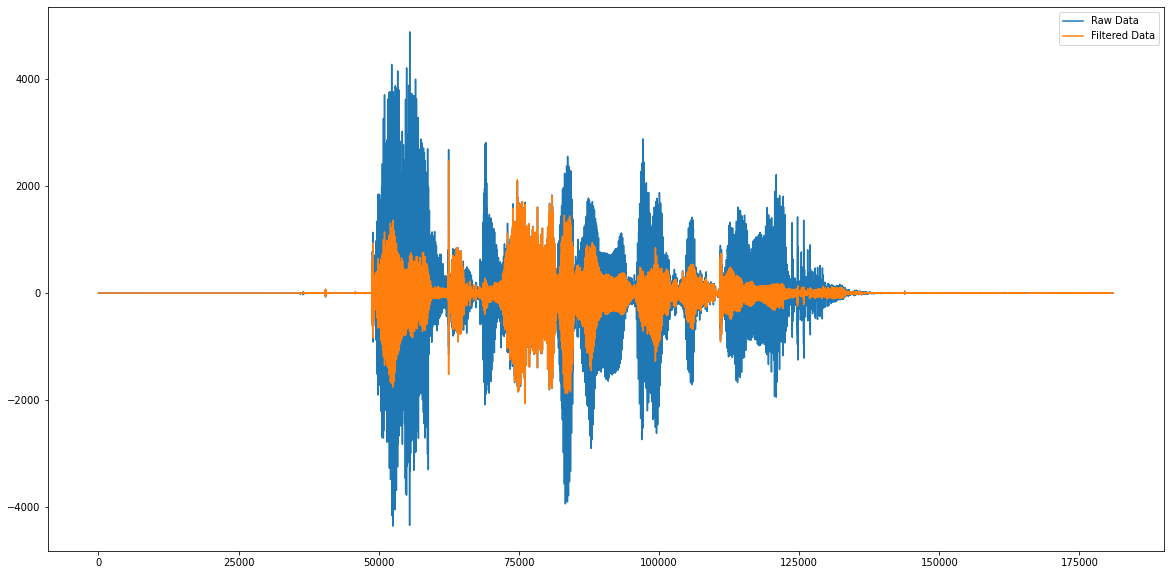

In [7]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

ax.plot(rawWavX, rawWavY, label = "Raw Data")
ax.plot(rawWavX, wavFiltered, label="Filtered Data")
ax.legend()

Синим цветов обозначен исходный сигнал, оранжевым - фильтрованный сигнал.

## 3. Детектор сигнал/шум

Определяем среднее сигнала по амплитуде (без учета знака): ${mid = \frac {1}{N} \sum_{k=0}^{N-1} \left | x(k) \right | }$.

Определяем порог детектора — ${Th = \alpha \cdot mid}$, где ${0 < \alpha < 1}$ подбирается экспериментально.

Задаем величину ”провала”(в отсчетах) — ${k}$. Обозначим ${y(i)}$ — сигнал после
детектирования.
- Событие **"начало сигнала"**. Если ${x(i)}$ в течении ${k}$ отсчетов превышает порог, ${y(i) = x(i)}$.
- Событие **"окончание сигнала"**. Если ${x(i)}$ в течении ${k}$ отсчетов меньше порога, ${y(i) = 0}$

В качестве примера ${\alpha = 0.8 , k = 10}$

In [8]:
def detectSignalNoise(wavData):
    mid = sum(map(lambda x: abs(x), wavData)) / len(wavData)
    alpha = 0.8
    Th = alpha * mid
    k = 10
    
    output = np.array([], dtype="int16")
    
    signalFramesStraight = 0
    noiseFramesStraight = 0
    for frame in wavData:
        if abs(frame) >= Th:
            signalFramesStraight += 1
            noiseFramesStraight = 0
        else:
            signalFramesStraight = 0
            noiseFramesStraight += 1
            
        if signalFramesStraight >= k:
            output = np.append(output, frame)
        else:
            if noiseFramesStraight >= k:
                output = np.append(output, 0)
            else:
                output = np.append(output, frame)
    
    return Th, output

In [9]:
Th, rawWavWithoutNoise = detectSignalNoise(rawWavY)

writeWav("rawWavWithoutNoise", wavFile.getparams(), rawWavWithoutNoise)

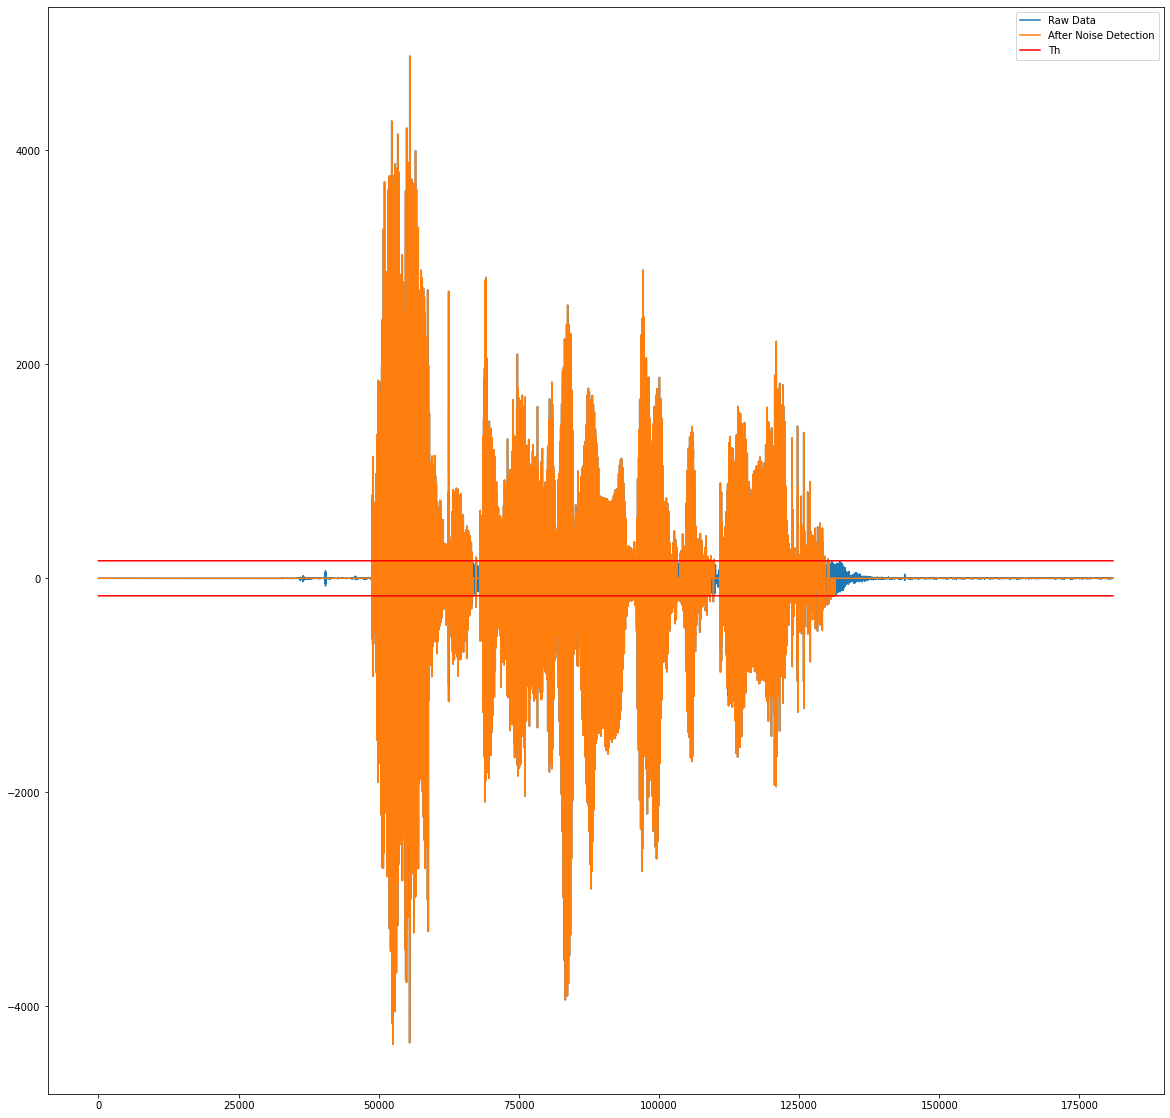

In [10]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

ax.plot(rawWavX, rawWavY, label = "Raw Data")
ax.plot(rawWavX, rawWavWithoutNoise, label="After Noise Detection")
ax.plot(rawWavX, [Th for i in rawWavX], color="red", label="Th")
ax.plot(rawWavX, [-1 * Th for i in rawWavX], color="red")
ax.legend()

Синим цветов обозначен исходный сигнал, оранжевым - сигнал с удаленым шумом, а красная линия - порог сигнал/шум.

В исходном файле изначально было немного шума. Посмотрим, как работает детектор на сигнале, в который заранее был добавлен шум.

In [11]:
import random
def addNoise(wavData):
    mid = sum(map(lambda x: abs(x), wavData)) / len(wavData)
    alpha = 0.8
    Th = alpha * mid
    
    output = np.array([], dtype="int16")
    
    for frame in wavData:
        if abs(frame) < Th:
            output = np.append(output, random.randint(-1 * int(Th) - 1, int(Th) - 1))
        else:
            output = np.append(output, frame)
            
    return output

wavWithNoise = addNoise(rawWavY)
writeWav("wavWithNoise", wavFile.getparams(), wavWithNoise)

Th, wavWithoutNoise = detectSignalNoise(wavWithNoise)
writeWav("wavWithoutNoise", wavFile.getparams(), wavWithoutNoise)

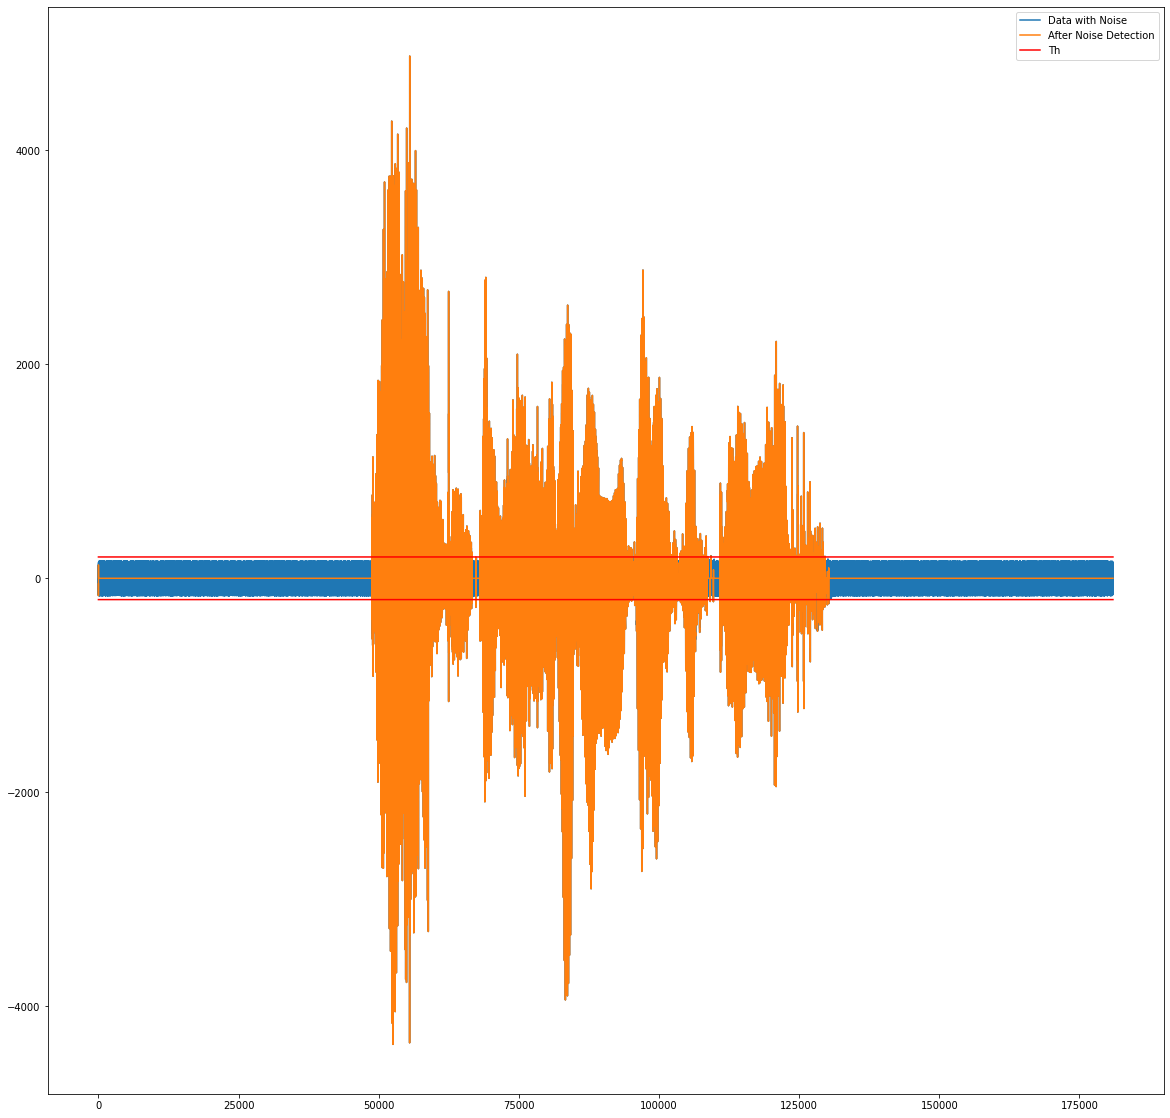

In [12]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

ax.plot(rawWavX, wavWithNoise, label = "Data with Noise")
ax.plot(rawWavX, wavWithoutNoise, label="After Noise Detection")
ax.plot(rawWavX, [Th for i in rawWavX], color="red", label="Th")
ax.plot(rawWavX, [-1 * Th for i in rawWavX], color="red")
ax.legend()

Синим цветов обозначен исходный сигнал, оранжевым - сигнал с удаленым шумом, а красная линия - порог сигнал/шум.

## 4. Эффект Эхо

Ревербератор реализован, как набор линий задержки. Число линий задержки ${N_L > 8}$.

Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): ${\alpha_1 > \alpha_2 > ... > \alpha_{N_L}}$.

Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

Желаемое соотношение между "сухим" и обработанным сигналом задается коэффициентом применимости ${\gamma}$.

Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset): 
- Для ручного режима регулируется пользователем задается максимальная задержка ${D1}$, а величины остальных определяются автоматически через нее: ${D_i = D_1 * 2^{\frac{1 - i}{N_L}} , i = 2, . . . ,N_L}$.
- Для готовой конфигурации пользователь вручную задает последовательность ${D_1 > D_2 > ... > D_{N_L}}$.

В данном примере весовые коэффициенты генерируются случайным образом, а задержки определяются по заданной максимальной задержке ${D_1 = 2400}$. Гамма ${\gamma = 0.5}$

In [13]:
def lowPassFilter(wavData, sampleRate):
    filterFreq = 2000
    wn = 2 * (filterFreq / sampleRate)
    b, a = signal.butter(1, wn, "lowpass")
    return np.array(signal.filtfilt(b, a, wavData), dtype="int16")

def getSignalWithReverb(wavData, sampleRate, delayValues, delayCoef, gamma):
    signalEcho = np.zeros(len(wavData))
    
    totalDelay = 0
    for delayIndex, delay in enumerate(delayValues):
        totalDelay += delay
        signalWithDelay = np.roll(wavData, totalDelay) * delayCoef[delayIndex]
        signalWithDelay[:totalDelay] = 0
        signalEcho += signalWithDelay
        
    signalEchoFiltered = lowPassFilter(signalEcho, sampleRate)
    signalEchoFiltered = signalEchoFiltered * gamma
    
    return wavData + signalEchoFiltered
    
        

delayLinesAmount = 10
delayCoef = np.sort(np.random.rand(delayLinesAmount))[::-1]

gamma = 0.5

delay = np.array([2400])

for i in range(2, len(delayCoef) + 1):
    value = delay[0] * 2 ** ((1 - i) / len(delayCoef))
    delay = np.append(delay, int(value))

wavWithReverb = getSignalWithReverb(rawWavY, sampleRate, delay, delayCoef, gamma)
writeWav("wavWithReverb", wavFile.getparams(), wavWithReverb)

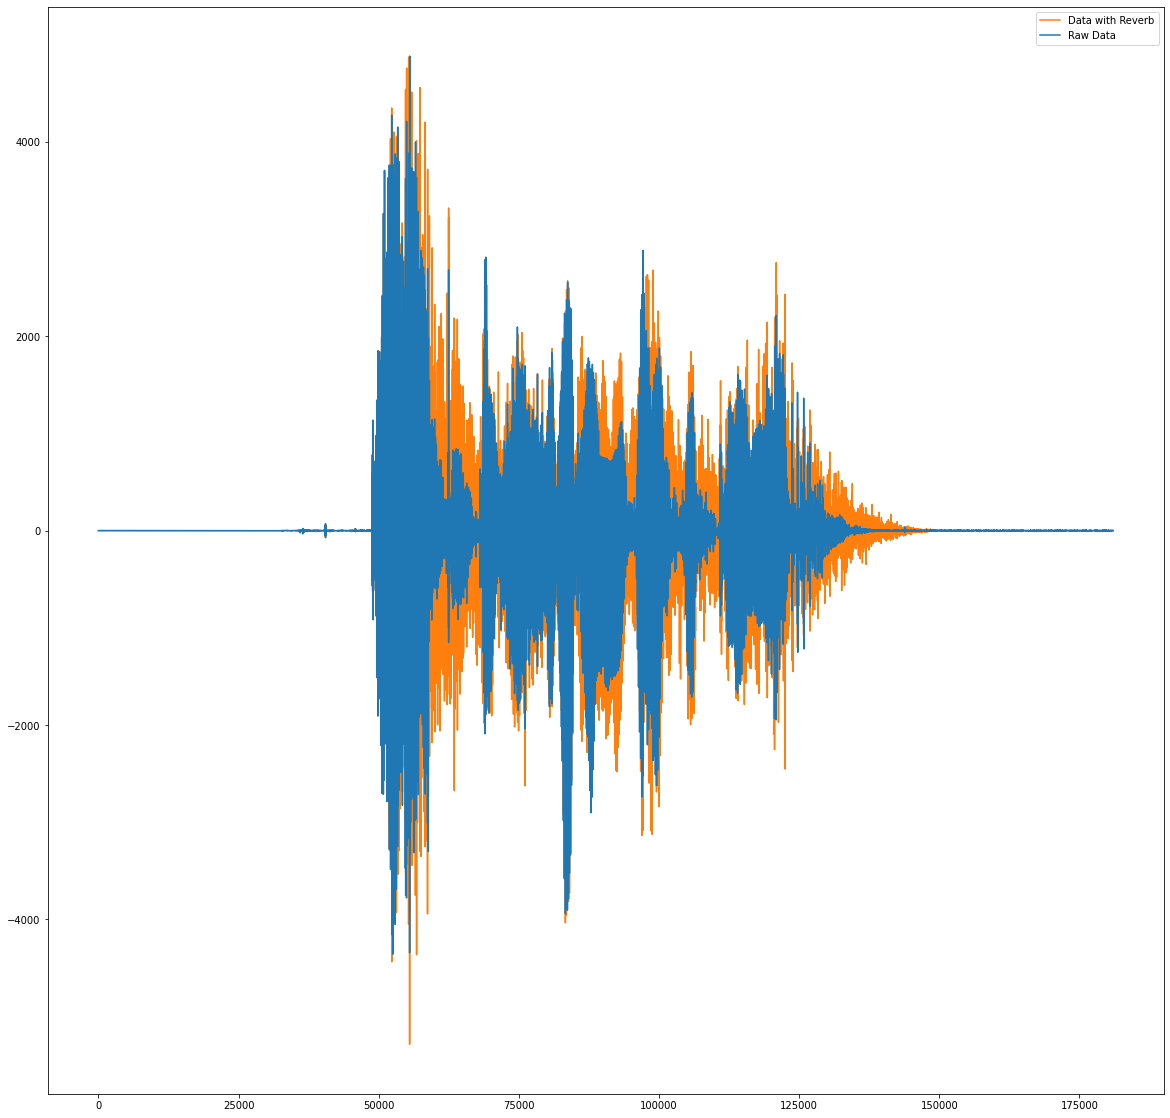

In [14]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

ax.plot(rawWavX, wavWithReverb, label="Data with Reverb", color="#ff7f0e")
ax.plot(rawWavX, rawWavY, label="Raw Data", color="#1f77b4")
ax.legend()

Синим цветов обозначен исходный сигнал, оранжевым - сигнал с эхо.

## 5. Distortion

Обозначим входной сигнал и выходной сигналы, соответственно как ${x(i)}$ и ${y(i), i = 0,1, . . . ,N - 1}$.

Пользователь задает порог — ${Th}$ и максимальное значение сигнала ${Max > Th}$.

Тогда ${Y(i) = \left\{\begin{matrix}
x(i), \left |x(i)\right| \leq Th
\\ 
Max \cdot sign(x(i)), |x(i)| > T h
\end{matrix}\right.}$.


В данном примере в качестве порога было взято значение ${Th = 0.8 * \frac {1}{N} \sum_{k=0}^{N-1} \left | x(k) \right | }$, а в качестве максимального значения - максимальное значение переменной типа **int16**.

In [15]:
mid = sum(map(lambda x: abs(x), rawWavY)) / len(rawWavY)
alpha = 0.8
Th = alpha * mid

maxValue = np.iinfo(np.int16).max

wavDistorted = [frame if abs(frame) <= Th else maxValue * np.sign(frame) for frame in rawWavY]
writeWav("wavDistorted", wavFile.getparams(), wavDistorted)

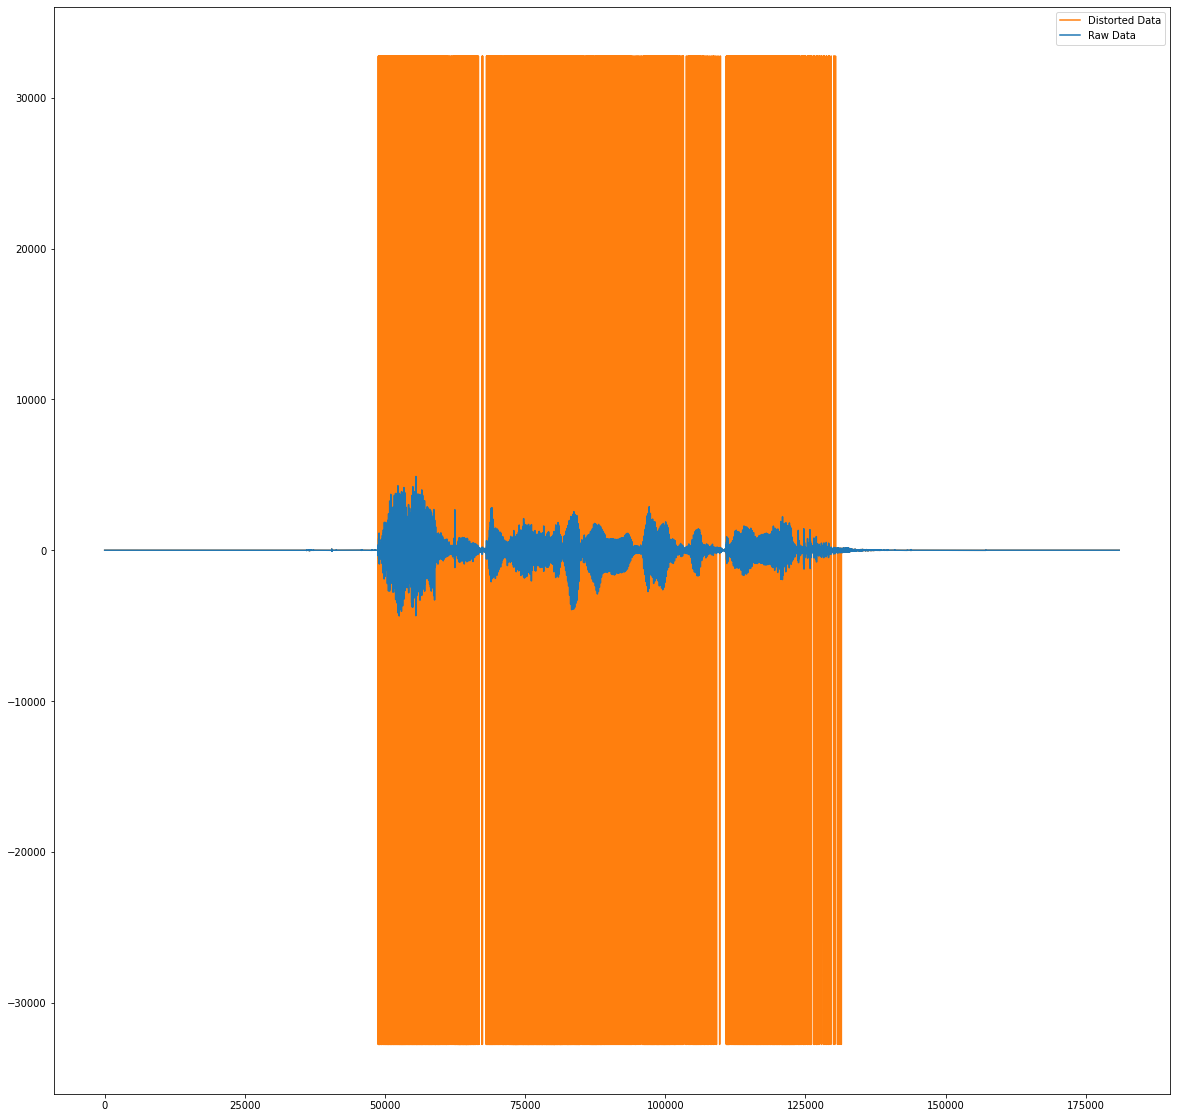

In [16]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

ax.plot(rawWavX, wavDistorted, label="Distorted Data", color="#ff7f0e")
ax.plot(rawWavX, rawWavY, label="Raw Data", color="#1f77b4")
ax.legend()

Синим цветов обозначен исходный сигнал, оранжевым - перегруженный сигнал.